## MediPal -- Data Preprocessing

### In this section, I preprocessed the dataset:
![](../assets/screenshots/preprocess.PNG "")
1. **Check for Sensitive Information**

   Look for any potential PII, payment card details, or other confidential data.

   Even one piece of problematic data can spoil the entire system.

2. **Augment relationship between drug name, sub-title and sub-content**

   I found a lot of sub-titles or sub-contents have no drug's name. They contiain 'this medicine','this drug' or pronoun instead of drug name.

   It is meaningless, if I embed them to vector db. So I replaced those pronoun with drug names.

### **Review Basic Statistics**

| Metric                    | Value    |
|---------------------------|----------|
| MedicineCount             | 7,391    |
| SubContentCount           | 72,114   |
| Total words               | 9,077,218|
| MinContentLength          | 4        |
| MaxContentLength          | 2,059    |
| LessThan500WordsCount     | 70,255   |
| LargerThan500WordsCount   | 1,859    |


In [1]:
import os
import re
import json
from pathlib import Path
import warnings
import langid
from bs4 import BeautifulSoup

In [2]:
# This function will load the json file to json object
def load_json_list(path: str):    
    with open(path, mode = "r", encoding="utf-8") as f:
        return json.load(f)

In [3]:
workspace_base_path = os.getcwd()
dataset_path = os.path.join(workspace_base_path, "datasets", "medlineplus_drugs.json") 
print(dataset_path)

c:\Users\Montr\AI_Projects\MediPal\1_DataPipeline\datasets\medlineplus_drugs.json


In [4]:
data = load_json_list(dataset_path)

In [7]:
data[:1]

[{'id': 1,
  'drug_name': 'Phenylephrine',
  'pronunciation': "pronounced as (fen il ef' rin)",
  'url': 'https://medlineplus.gov/druginfo/meds/a606008.html',
  'subtitles': [{'title': 'Why is this medication prescribed?',
    'content': '<div class="section-body" id="section-1"><p>Phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. It is also used to relieve sinus congestion and pressure. Phenylephrine will relieve symptoms but will not treat the cause of the symptoms or speed recovery. Phenylephrine is in a class of medications called nasal decongestants. It works by reducing swelling of the blood vessels in the nasal passages.</p></div>'},
   {'title': 'How should this medicine be used?',
    'content': '<div class="section-body" id="section-2"><p>Phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. It is usually taken every 4 hours as needed. Follow the directions on your prescription label or the package label 

In [5]:
# Cleaning html tag for sub-content
# testing basic function
def remove_html_tag(html: str):
    return BeautifulSoup(html, "html.parser").get_text(separator="", strip=True)

In [6]:
for d in data:
    for t in d["subtitles"]:        
        t["content"] = remove_html_tag(t["content"])

In [7]:
# Sensitive info checking
# This function will replace PII string with other string
def remove_pii(text):
    text = re.sub(r'\b[\w.-]+?@\w+?\.\w{2,4}\b', '[EMAIL]', text)
    text = re.sub(r'\b(?:\d[ -]*?){13,16}\b', '[CREDIT_CARD]', text)
    text = re.sub(r'\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3,4}[-.\s]?\d{4}\b', '[PHONE]', text)
    return text

def warn_if_pii(text: str):
    """
    Scan the input text for emails, credit card numbers, or phone numbers.
    If any are found, issue a warning and display the full text.
    """
    # Compile regex patterns
    email_pattern = re.compile(r'\b[\w.-]+?@\w+?\.\w{2,4}\b')
    credit_pattern = re.compile(r'\b(?:\d[ -]*?){13,16}\b')
    phone_pattern = re.compile(
        r'\b(?:\+?\d{1,3}[-.\s]?)?(?:\(?\d{2,4}\)?[-.\s]?)?\d{3,4}[-.\s]?\d{4}\b'
    )

    # Find matches
    emails = email_pattern.findall(text)
    credits = credit_pattern.findall(text)
    phones = phone_pattern.findall(text)

    # If any matches exist, warn with details
    if emails or credits or phones:
        matches = {
            "emails": emails,
            "credit_cards": credits,
            "phones": phones
        }
        warnings.warn(
            f"Possible PII detected: {matches}\nFull text:\n{text}",
            category=UserWarning
        )        

In [8]:
# Check if it contains PII
for d in data[:200]:
    for t in d["subtitles"]:
        warn_if_pii(t["title"])
        warn_if_pii(t["content"])

C:\Users\Montr\AppData\Local\Temp\ipykernel_14920\686340581.py:33: UserWarning: Possible PII detected: {'emails': [], 'credit_cards': [], 'phones': ['1-800-332-1088']}
Full text:
Phenylephrine may cause side effects. Some side effects can be serious. If you experience any of these symptoms, stop using phenylephrine and call your doctor:nervousnessdizzinesssleeplessnessPhenylephrine may cause other side effects. Call your doctor if you have any unusual problems while taking this medication.If you experience a serious side effect, you or your doctor may send a report to the Food and Drug Administration's (FDA) MedWatch Adverse Event Reporting program online (https://www.fda.gov/Safety/MedWatch) or by phone (1-800-332-1088).
  warnings.warn(
C:\Users\Montr\AppData\Local\Temp\ipykernel_14920\686340581.py:33: UserWarning: Possible PII detected: {'emails': [], 'credit_cards': [], 'phones': ['1-800-222-1222']}
Full text:
In case of overdose, call the poison control helpline at 1-800-222-1222.

In [9]:
# The phone looks like public number. I don't think it is PII. But remove it.
for d in data:
    for t in d["subtitles"]:
        t["title"] = remove_pii(t["title"])
        t["content"] = remove_pii(t["content"])

In [10]:
# Check one more time just in case 
for d in data[:200]:
    for t in d["subtitles"]:
        warn_if_pii(t["title"])
        warn_if_pii(t["content"])

In [21]:
# Check if it contains other language content besides English.
def warn_if_otherlang(text: str, lang="en"):

    detected_lang, confidence = langid.classify(text)    
    if lang != detected_lang:
        warnings.warn(
            f"Other language {detected_lang} detected in: {text}\n",
            category=UserWarning
        )    


def filter_by_language(text, lang="en"):
    detected_lang, confidence = langid.classify(text)    
    if lang != detected_lang:
        return ""
    
    return text

In [22]:
for d in data[100:150]:
    for t in d["subtitles"]:
        warn_if_otherlang(t['title'])
        warn_if_otherlang(t["content"])

C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\3604922057.py:6: UserWarning: Other language es detected in: Keep your vaccination card

  warnings.warn(
C:\Users\Montr\AppData\Local\Temp\ipykernel_17848\3604922057.py:6: UserWarning: Other language es detected in: Adenoviral vector COVID-19 vaccineAdenovirus 26 vector COVID-19 vaccineAd26.COV2.SCOVID-19 Vaccine, Johnson and Johnson

  warnings.warn(


##### As this is the medicine data, it is normal to contains some other languages like latín.
##### So I will not replace that content in the project

##### Next, **Identify Augmenting Needs**

In [11]:
# Now check how many distinct title the whole data has
titles_set = set([t['title'] for d in data for t in d["subtitles"]])

In [12]:
sorted(titles_set, key=len, reverse=True)

['Can I be charged an administration fee for receiving the COVID-19 vaccine?',
 'What are the risks from inactivated or recombinant influenza vaccine?',
 'What are the benefits of the Janssen (Johnson and Johnson) vaccine?',
 'What should I know about storage and disposal of this medication?',
 'Will the Janssen (Johnson and Johnson) vaccine give me COVID-19?',
 'What are the risks of the Janssen (Johnson and Johnson) vaccine?',
 'How is the Janssen (Johnson and Johnson) COVID-19 vaccine given?',
 'Who should not get or should wait to get the influenza vaccine?',
 'What is live, attenuated influenza vaccine-LAIV (nasal spray)?',
 'What are the benefits of the COVID-19 vaccine, adjuvanted?',
 'What should you tell the person who is giving the vaccine?',
 'What is the Countermeasures Injury Compensation Program?',
 'Who should get pneumococcal conjugate vaccine and when?',
 'What are the risks from meningococcal group B vaccines?',
 'What are the risks of the COVID-19 vaccine, adjuvanted

##### Because the title is very important part at the retrieval stage. I have to embed meaningful title to vector DB so that I can retrieve related content based on query.
For example, if the title is 'How should this medicine be used?'. And the user's query is 'How should Phenylephrine be used?'

it is almost impossible to get the right document about Phenylephrine.

##### 1. I will replace 'this medicine' and 'this medication' in title and content with the medicine name so that the title has connection with the medicine.
##### 2. If there is no 'this medicine' or 'this medication' in title and content, I will add ' about [medicine name]' at the end.

In [13]:
# This function will augment the title so that it has a link with the medicine
def augment_title_content(**record):
    medicine_name = record["drug_name"]
    for t in record["subtitles"]:
        t["title"] = augment(t["title"].lower(), medicine_name)
        t["content"] = augment(t["content"].lower(), medicine_name)

def augment(kv, medicine_name: str):
    if kv.find("this medicine") > -1:
        return kv.replace("this medicine", medicine_name)
    elif kv.find("this medication") > -1:
        return kv.replace("this medication", medicine_name)
    elif kv.find(medicine_name) > -1:
        return kv
    else:
        return kv.replace("?", " ") + " about " + medicine_name

In [14]:
for d in data:
    augment_title_content(**d)

In [15]:
data[:3]

[{'id': 1,
  'drug_name': 'Phenylephrine',
  'pronunciation': "pronounced as (fen il ef' rin)",
  'url': 'https://medlineplus.gov/druginfo/meds/a606008.html',
  'subtitles': [{'title': 'why is Phenylephrine prescribed?',
    'content': 'phenylephrine is used to relieve nasal discomfort caused by colds, allergies, and hay fever. it is also used to relieve sinus congestion and pressure. phenylephrine will relieve symptoms but will not treat the cause of the symptoms or speed recovery. phenylephrine is in a class of medications called nasal decongestants. it works by reducing swelling of the blood vessels in the nasal passages. about Phenylephrine'},
   {'title': 'how should Phenylephrine be used?',
    'content': "phenylephrine comes as a tablet, a liquid, or a dissolving strip to take by mouth. it is usually taken every 4 hours as needed. follow the directions on your prescription label or the package label carefully, and ask your doctor or pharmacist to explain any part you do not unde

##### I am preparing next stage will be building RAG system. 
##### As the embedding model has limit input tokens number. Or I will say every LLM model has limit context length.
##### It is very important to check the minimum and maximum words number of the content so that I know the proper chunk size.

### **Review Basic Statistics**

In [20]:
drug_count = len(data)
lengths = [len(t["content"].split()) for d in data for t in d["subtitles"]]
min_len = min(lengths)
max_len= max(lengths)
print(f"Medicine count: {drug_count}\n")
print(f"Minimum length: {min_len}\n")
print(f"Maximum length: {max_len}")

Medicine count: 7391

Minimum length: 4

Maximum length: 2059


In [17]:
print(f"We have {len(lengths)} total sub-contents.")

We have 72114 total sub-contents.


In [16]:
print(f"{sum(lengths)} words.")

9077218 words.


##### We have 72114 subtitles and contents.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

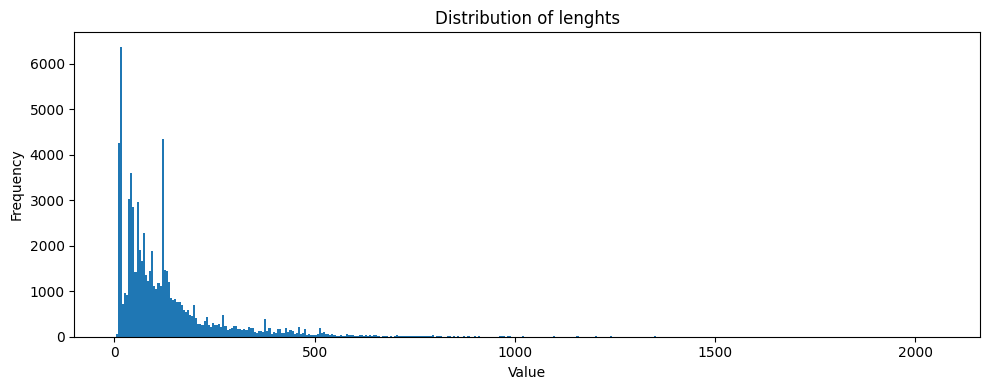

In [29]:
plt.figure(figsize=(10,4))
plt.hist(lengths, bins="auto")  # automatic binning for a sensible histogram
plt.title("Distribution of lenghts")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [19]:
less_500 = len([l for l in lengths if l <= 500])
larger_500 = len([l for l in lengths if l > 500])

print(f"Count of Content length is less than 500: {less_500}")
print(f"Count of Content length is larger than 500: {larger_500}")

Count of Content length is less than 500: 70255
Count of Content length is larger than 500: 1859


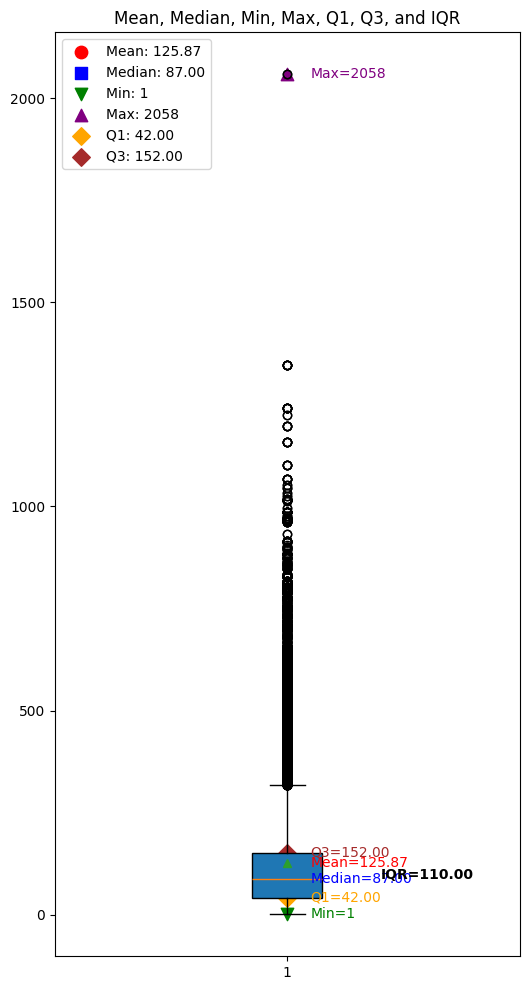

In [12]:
mean_val = np.mean(lengths)
median_val = np.median(lengths)
min_val = np.min(lengths)
max_val = np.max(lengths)
q1 = np.percentile(lengths, 25)
q3 = np.percentile(lengths, 75)
iqr = q3 - q1

# great boxplot
fig, ax = plt.subplots(figsize=(6, 12))
ax.boxplot(lengths, vert=True, patch_artist=True, showmeans=True)

ax.scatter(1, mean_val, color="red", marker="o", s=80, label=f"Mean: {mean_val:.2f}")
ax.scatter(1, median_val, color="blue", marker="s", s=80, label=f"Median: {median_val:.2f}")
ax.scatter(1, min_val, color="green", marker="v", s=80, label=f"Min: {min_val}")
ax.scatter(1, max_val, color="purple", marker="^", s=80, label=f"Max: {max_val}")
ax.scatter(1, q1, color="orange", marker="D", s=80, label=f"Q1: {q1:.2f}")
ax.scatter(1, q3, color="brown", marker="D", s=80, label=f"Q3: {q3:.2f}")

ax.text(1.05, mean_val, f"Mean={mean_val:.2f}", color="red", va="center")
ax.text(1.05, median_val, f"Median={median_val:.2f}", color="blue", va="center")
ax.text(1.05, min_val, f"Min={min_val}", color="green", va="center")
ax.text(1.05, max_val, f"Max={max_val}", color="purple", va="center")
ax.text(1.05, q1, f"Q1={q1:.2f}", color="orange", va="center")
ax.text(1.05, q3, f"Q3={q3:.2f}", color="brown", va="center")

ax.text(1.2, (q1+q3)/2, f"IQR={iqr:.2f}", color="black", va="center", fontsize=10, fontweight="bold")

ax.set_title("Mean, Median, Min, Max, Q1, Q3, and IQR")
ax.legend(loc="best")

plt.show()

### Summary:
##### As I analysized the data, we have 7,391 medicines and 72,114 sub-contents. Totally we got more than 9,077,218 words.
##### The distribution plots are the lengths of most sub-contents are less than 500 words.
##### The embedding model I will use to build RAG system is sentence-transformers/embeddinggemma-300m-medical
##### "max_position_embeddings": 1024 is the context window. That means we can feed maximum 1024 tokens to it, otherwise it will truncate the input.

In [18]:
save_to = os.path.join(workspace_base_path, "datasets", "cleaned_medicine_data.json")
out_path = Path(save_to)
out_path.parent.mkdir(parents=True, exist_ok=True)  # make folder if needed

with out_path.open("w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)